In [1]:
# https://www.kaggle.com/code/rajsing/quora-text-classification
import pandas as pd
import nltk

data_dir = './input'
train = data_dir + '/train.csv'
test = data_dir + '/test.csv'

# sub_df = pd.read_csv(sample)
test_df = pd.read_csv(test)
raw_df = pd.read_csv(train)
# raw_df

insincere_df = raw_df[raw_df.target==1]
# insincere_df.question_text.values[:10]

sincere_df = raw_df[raw_df.target==0]
sincere_df.question_text.values[:10]

nltk.download('punkt')
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

SAMPLE_SIZE = 50_000
sample_df = raw_df.sample(SAMPLE_SIZE, random_state=42)
sample_df

[nltk_data] Downloading package punkt to /Users/kkepins-
[nltk_data]     macwro_1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kkepins-
[nltk_data]     macwro_1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,qid,question_text,target
443046,56d324bb1e2c29f43b12,What is the most effective classroom managemen...,0
947549,b9ad893dc78c577f8a63,Can I study abroad after 10th class from Bangl...,0
523769,6689ebaeeb65b209a412,How can I make friends as a college junior?,0
949821,ba1e2c4a0fef09671516,How do I download free APK Minecraft: Pocket E...,0
1030397,c9ea2b69bf0d74626f46,"Like Kuvera, is ""Groww"" also a free online inv...",0
...,...,...,...
1114737,da6f81be4009ccf461ba,Why do so many people want the government to t...,0
1061387,cff924434fe209f14b77,Why is the battery blinking when I open the ai...,0
1260836,f716bbf34983c6ddc707,Any real life example that you faced in your l...,0
475581,5d20bb6741870ee265c4,How should I prepare for UPES entrance examina...,0


In [2]:
# Text Preprocessing Techniques
import sklearn as skl
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split

start = time.time()
# Removing Stop Words, Tokenization & Stemmanization
def tokenizer(text):
    stemmer = nltk.stem.snowball.SnowballStemmer(language='english')
    return [stemmer.stem(word) for word in nltk.tokenize.word_tokenize(text) ]

vectorizer = skl.feature_extraction.text.CountVectorizer(lowercase=True
                             , tokenizer=tokenizer
                             , stop_words=stop_words
                             , max_features=1000)

vectorizer.fit(sample_df.question_text)
inputs = vectorizer.transform(sample_df.question_text).toarray()

print(inputs.shape) # (n_samples, n_features)

# stratify
train_inputs, val_inputs, train_targets, val_targets = train_test_split(inputs
                                                                        , sample_df.target
                                                                        , test_size=0.5
                                                                        , random_state=42)
print(train_inputs)

print("--- %s seconds ---" % (time.time() - start))


/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-upskills-eseJr18D/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-upskills-eseJr18D/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


(50000, 1000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
--- 12.834693193435669 seconds ---


In [3]:
import tensorflow as tf

start = time.time()
vocab_size = len(vectorizer.vocabulary_)
# The embedding dimension
embedding_dim = 8
# Number of RNN units
rnn_units = 100
#batch size
batch_size=90
# num of NER classes
num_classes = train_inputs.shape[1]
dropout=0.2

# budowanie modelu
model = keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=8, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(padded_sequences, labels, epochs=10)



# Konwersja wektorów na tensor i zdefiniowanie warstwy Embedding
keras_inputs = tf.keras.layers.Input(shape=(train_inputs.shape[1],))
# keras_embedding = tf.keras.layers.Embedding(input_dim=train_inputs.shape[0], output_dim=train_inputs.shape[0], input_length=10)(keras_inputs)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(train_inputs.shape[1],)),
    tf.keras.layers.Embedding(input_dim=train_inputs.shape[1], output_dim=embedding_dim, input_length=train_inputs.shape[1], trainable=False),
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=rnn_units,
    #                                                    return_sequences=True,
    #                                                    dropout=dropout,
    #                                                    kernel_initializer=tf.keras.initializers.he_normal())),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(rnn_units, activation='relu')),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation="softmax")
    # tf.keras.layers.Dense(units=1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='mse')
model.fit(train_inputs, train_targets, epochs=10, batch_size=32)

print("--- %s seconds ---" % (time.time() - start))

2023-02-10 15:39:17.884249: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-10 15:39:17.884526: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Epoch 1/10


2023-02-10 15:39:19.230907: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-10 15:39:19.484496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 158s 200ms/step - loss: 0.0618
Epoch 2/10
782/782 [==============================] - 158s 201ms/step - loss: 0.0618
Epoch 3/10
782/782 [==============================] - 159s 203ms/step - loss: 0.0618
Epoch 4/10
782/782 [==============================] - 162s 207ms/step - loss: 0.0618
Epoch 5/10
782/782 [==============================] - 164s 209ms/step - loss: 0.0618
Epoch 6/10
782/782 [==============================] - 154s 197ms/step - loss: 0.0618
Epoch 7/10
782/782 [==============================] - 153s 195ms/step - loss: 0.0618
Epoch 8/10
782/782 [==============================] - 154s 196ms/step - loss: 0.0618
Epoch 9/10
782/782 [==============================] - 160s 205ms/step - loss: 0.0618
Epoch 10/10
782/782 [==============================] - 155s 198ms/step - loss: 0.0618
--- 1576.9476408958435 seconds ---


In [34]:
from sklearn.metrics import accuracy_score, f1_score
from libs.simpleplotter import simple_roc

val_pred = model.evaluate(val_inputs)

val_pred

# print('Val Accuracy: ', accuracy_score(val_targets, val_pred))
# print('Val F1: ', f1_score(val_targets, val_pred))

# print('For Sincere: ', model.predict(vectorizer.transform(sincere_df.question_text.values[:10])))
# print('For Insincere: ', model.predict(vectorizer.transform(insincere_df.question_text.values[:10])))
# simple_roc(val_targets, val_pred)



938/938 [==============================] - 3s 3ms/step - loss: 0.0000e+00


0.0

In [13]:

# BiLSTM model

import tensorflow as tf

start = time.time()
vocab_size = len(vectorizer.vocabulary_)
# The embedding dimension
embedding_dim = 64
# Number of RNN units
rnn_units = 100
#batch size
batch_size=90
# num of NER classes
num_classes = inputs.shape[1]
dropout=0.2

# model.add(tf.keras.layers.Embedding(1000, 64, input_length=10))

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True,
    #           batch_input_shape=[batch_size,
    #                              None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=rnn_units,
                       return_sequences=True,
                       dropout=dropout,
                       kernel_initializer=
                           tf.keras.initializers.he_normal())),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(rnn_units, activation='relu')),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy"])
# model.summary()

# td = tf.data.Dataset()
# ti = td.sample_from_datasets(train_inputs)

# train_inputs_batched = ti.batch(batch_size)
# val_inputs_batched = val_inputs.batch(batch_size)

# model.fit(train_inputs_batched, epochs=5)
model.fit(train_inputs, epochs=5)

# model.evaluate(val_inputs_batched)
model.evaluate(train_inputs)

print("--- %s seconds ---" % (time.time() - start))


Epoch 1/5


TypeError: in user code:

    File "/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-upskills-eseJr18D/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-upskills-eseJr18D/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-upskills-eseJr18D/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-upskills-eseJr18D/lib/python3.10/site-packages/keras/engine/training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-upskills-eseJr18D/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    TypeError: Exception encountered when calling layer "embedding_4" "                 f"(type Embedding).
    
    Failed to convert elements of SparseTensor(indices=Tensor("DeserializeSparse:0", shape=(None, 2), dtype=int64), values=Tensor("sequential_4/embedding_4/Cast:0", shape=(None,), dtype=int32), dense_shape=Tensor("stack:0", shape=(2,), dtype=int64)) to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.
    
    Call arguments received by layer "embedding_4" "                 f"(type Embedding):
      • inputs=<tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x1385af3a0>


/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-upskills-eseJr18D/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy:  0.9504428571428571
F1:  0.4457581083240134
For Sincere:  [0 0 0 0 0 0 1 0 0 0]
For Insincere:  [0 0 1 1 0 0 0 1 0 0]
Val Accuracy:  0.9467
Val F1:  0.40843507214206437


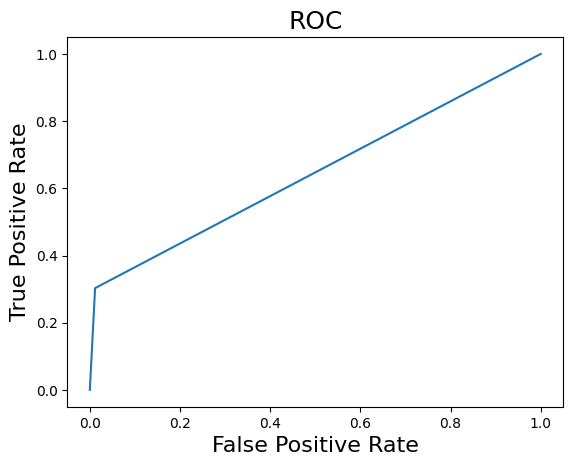

In [19]:
# Logistic Regression, just for comparizon

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from libs.simpleplotter import simple_roc

MAX_ITER = 1000
model = LogisticRegression(max_iter=1000, solver='sag')

model.fit(train_inputs, train_targets)

train_pred = model.predict(train_inputs)

print('Accuracy: ', accuracy_score(train_targets, train_pred))
print('F1: ', f1_score(train_targets, train_pred))

print('For Sincere: ', model.predict(vectorizer.transform(sincere_df.question_text.values[:10])))
print('For Insincere: ', model.predict(vectorizer.transform(insincere_df.question_text.values[:10])))

val_pred = model.predict(val_inputs)

print('Val Accuracy: ', accuracy_score(val_targets, val_pred))
print('Val F1: ', f1_score(val_targets, val_pred))

# print('For Sincere: ', model.predict(vectorizer.transform(sincere_df.question_text.values[:10])))
# print('For Insincere: ', model.predict(vectorizer.transform(insincere_df.question_text.values[:10])))
simple_roc(val_targets, val_pred)
